### Requirements import

In [1]:
import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import cv2
import gc
import os
import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.python.client import device_lib
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

### Use GPU

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1}, log_device_placement=True ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro GV100, pci bus id: 0000:73:00.0, compute capability: 7.0



In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10158311721324836894
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31792824320
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3112259204063900404
physical_device_desc: "device: 0, name: Quadro GV100, pci bus id: 0000:73:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


### Import Train set 

In [4]:
x = np.load('../Preprocessing/train_crop.npy',allow_pickle=True).astype(np.float32)/255.0
y_label = np.load('../Preprocessing/train.npy',allow_pickle=True)

In [5]:
# Extract the y from y_label
y = y_label[:,0]

### Build the new model based on ResNet50

In [6]:
def getmodel(num_classes=256):
    '''
    Build the new model based on ResNet50
    
    Argument:
    num_classes -- (int) number of classes
    
    Return:
    model -- the new compiled model
    '''
    
    orig_model = ResNet50(include_top=False, weights='imagenet', pooling='avg', classes=num_classes)
    densenet_out = orig_model.layers[-1].output
    out = Dense(256, activation='softmax', kernel_initializer='glorot_uniform')(densenet_out)
    model = Model(inputs=orig_model.input, outputs=out)
    model.compile(loss= "sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [7]:
densemodel = getmodel(256)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
densemodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

### Train the model and save the best weights and history

In [9]:
filepath="./Models/ResNet50_crop.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]
history = densemodel.fit(x, y, epochs=12, batch_size=32, validation_split=0.25, callbacks=callbacks_list)

Train on 17869 samples, validate on 5957 samples
Epoch 1/12
17869/17869 [==============================] - ETA: 0s - loss: 4.2795 - accuracy: 0.1678

C:\Users\skhatta\AppData\Local\anaconda3\envs\s_myenv\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.00655, saving model to ./Models\ResNet50_crop.hdf5
17869/17869 [==============================] - 224s 13ms/sample - loss: 4.2795 - accuracy: 0.1678 - val_loss: 8.0512 - val_accuracy: 0.0065
Epoch 2/12
17869/17869 [==============================] - ETA: 0s - loss: 2.6664 - accuracy: 0.3995
Epoch 2: val_accuracy improved from 0.00655 to 0.30922, saving model to ./Models\ResNet50_crop.hdf5
17869/17869 [==============================] - 143s 8ms/sample - loss: 2.6664 - accuracy: 0.3995 - val_loss: 3.3113 - val_accuracy: 0.3092
Epoch 3/12
17869/17869 [==============================] - ETA: 0s - loss: 1.8559 - accuracy: 0.5487
Epoch 3: val_accuracy improved from 0.30922 to 0.44234, saving model to ./Models\ResNet50_crop.hdf5
17869/17869 [==============================] - 146s 8ms/sample - loss: 1.8559 - accuracy: 0.5487 - val_loss: 2.5691 - val_accuracy: 0.4423
Epoch 4/12
17869/17869 [==============================] - ETA: 0s - loss: 1.2732 - a

In [10]:
np.save("./History/history_resnet50.npy",history.history)

In [11]:
#release RAM
del x, y
gc.collect()

0

### Load the history and plot the curves for accuracy and loss

In [12]:
history = np.load("./History/history_resnet50.npy", allow_pickle=True).item()

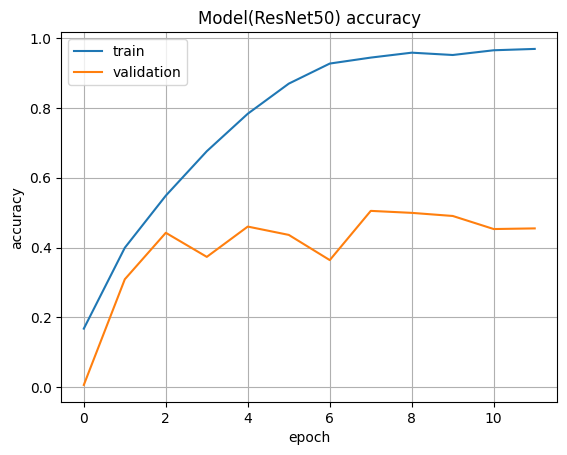

In [15]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model(ResNet50) accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()

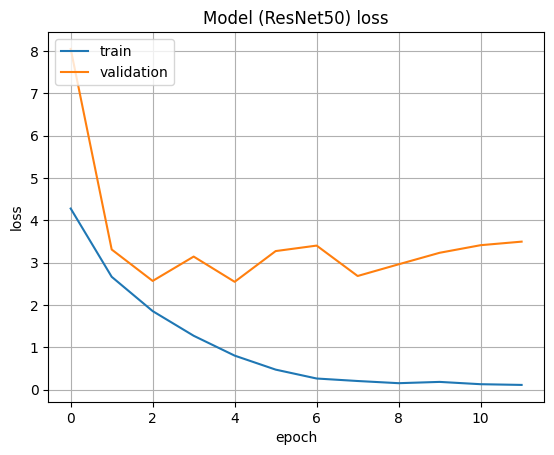

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model (ResNet50) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()

In [17]:
#Import test dataset
X_test = np.load('../Preprocessing/test_crop.npy',allow_pickle=True)/255.
# Y_test = np.load('onehot_y_test.npy')
y_test = np.load('../Preprocessing/test.npy',allow_pickle=True)

### Load the weights of the best model and evaluate the performance

In [18]:
densemodel.load_weights('./Models/ResNet50_crop.hdf5')

In [19]:
eva = densemodel.evaluate(X_test, y_test[:, 0], batch_size=32, verbose=1, sample_weight=None)
print()
print("Loss = " + str(eva[0]))
print("Test Accuracy = " + str(eva[1]))


Loss = 2.7974310709054717
Test Accuracy = 0.49513096


### Test the model with the sample image

In [25]:
# Change the path accordingly where the dataset is placed
def label_dict(path = '../../Dataset'):
    '''
    To build a dict to record the label
    (need to import glob package)
    Arguments:
    path -- The path of Image Set
    
    Returns:
    dict_l -- return a dict that contains 256 classes
    '''
    all_label = glob.glob(path + '/256_ObjectCategories/*')
    all_label.sort()
    
    dict_l = {}
    class_num = len(all_label) - 1
    for i in range(class_num):
        dict_l[i+1] = all_label[i].split('.')[-1]
    
    return dict_l

In [26]:
#predict a new image
predict_num = 1543
dict_label = label_dict()

In [27]:
dict_label

{1: 'ak47',
 2: 'american-flag',
 3: 'backpack',
 4: 'baseball-bat',
 5: 'baseball-glove',
 6: 'basketball-hoop',
 7: 'bat',
 8: 'bathtub',
 9: 'bear',
 10: 'beer-mug',
 11: 'billiards',
 12: 'binoculars',
 13: 'birdbath',
 14: 'blimp',
 15: 'bonsai-101',
 16: 'boom-box',
 17: 'bowling-ball',
 18: 'bowling-pin',
 19: 'boxing-glove',
 20: 'brain-101',
 21: 'breadmaker',
 22: 'buddha-101',
 23: 'bulldozer',
 24: 'butterfly',
 25: 'cactus',
 26: 'cake',
 27: 'calculator',
 28: 'camel',
 29: 'cannon',
 30: 'canoe',
 31: 'car-tire',
 32: 'cartman',
 33: 'cd',
 34: 'centipede',
 35: 'cereal-box',
 36: 'chandelier-101',
 37: 'chess-board',
 38: 'chimp',
 39: 'chopsticks',
 40: 'cockroach',
 41: 'coffee-mug',
 42: 'coffin',
 43: 'coin',
 44: 'comet',
 45: 'computer-keyboard',
 46: 'computer-monitor',
 47: 'computer-mouse',
 48: 'conch',
 49: 'cormorant',
 50: 'covered-wagon',
 51: 'cowboy-hat',
 52: 'crab-101',
 53: 'desk-globe',
 54: 'diamond-ring',
 55: 'dice',
 56: 'dog',
 57: 'dolphin-101'

In [28]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

The image category is: bowling-ball
The corresponding label of image is: 17


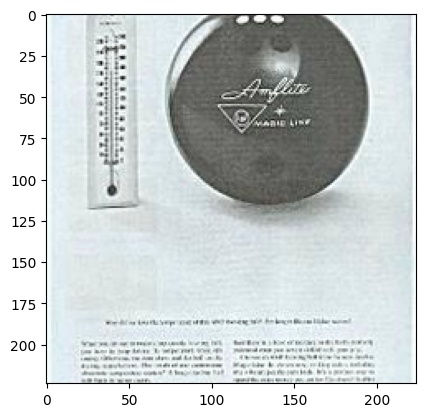

In [29]:
X_predict = X_test[predict_num]
print('The image category is: ' + dict_label[y_test[:, 0][predict_num]+1])
print('The corresponding label of image is: '+str(y_test[:, 0][predict_num]+1))
plt.ion()
plt.imshow(X_predict)
plt.show()

In [30]:
#predict
predict_vector = densemodel.predict(np.expand_dims(X_predict, axis=0))
index = np.where(predict_vector[0] == np.max(predict_vector[0]))
print('The predict label of image is: '+str(index[0][0]+1))
print('The image is predicted with a probability of: '+str(predict_vector[0, index[0][0]]))
print('This image is: ' + dict_label[index[0][0] + 1])

C:\Users\skhatta\AppData\Local\anaconda3\envs\s_myenv\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


The predict label of image is: 248
The image is predicted with a probability of: 0.7932354
This image is: yarmulke
